In [1]:
import pandas
import numpy 
import numpy.linalg as la
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
data = pandas.read_csv('../data/hurr_database/atlantic.csv')

In [3]:
data.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],
      dtype='object')

In [4]:
location = data[["ID", "Name","Latitude", "Longitude", "Status", "Maximum Wind"]]
location = location[35683:]

In [5]:
location

,ID,Name,Latitude,Longitude,Status,Maximum Wind
35683,AL011986,ANDREW,27.4N,76.0W,SD,30
35684,AL011986,ANDREW,28.4N,76.4W,SD,30
35685,AL011986,ANDREW,29.1N,77.0W,SD,30
35686,AL011986,ANDREW,29.7N,77.5W,TS,35
35687,AL011986,ANDREW,30.2N,77.8W,TS,40
...,...,...,...,...,...,...
49100,AL122015,KATE,41.3N,50.4W,EX,55
49101,AL122015,KATE,41.9N,49.9W,EX,55
49102,AL122015,KATE,41.5N,49.2W,EX,50
49103,AL122015,KATE,40.8N,47.5W,EX,45


In [6]:
hurr_KATE = location[location["ID"] == 'AL122015']

In [7]:
def compute_distances_from_county(hurr, lat_county, lon_county):
    lat = list(hurr['Latitude'])
    lon = list(hurr['Longitude'])
    for i in range(0,len(hurr)):
        l = lat[i]
        lo = lon[i]
        if l[-1] == 'S':
            lat[i] = '-' + l[:-1]
        else:
            lat[i] = l[:-1]

        if lo[-1] == 'W':
            lon[i] = '-' + lo[:-1]
        else:
            lon[i] = lo[:-1]
    lat_in_radians = [radians(float(_)) for _ in lat]
    lon_in_radians = [radians(float(_)) for _ in lon]
    coords = list(zip(lat_in_radians, lon_in_radians))
    county = list((radians(lat_county), radians(lon_county)))
    distance = list()
    for i in range(0, len(lat_in_radians)):
        distance.append((haversine_distances([list(coords[i]), county])[1,0]) * 6371000/1000)
    return distance

In [8]:
distances = compute_distances_from_county(location, 38.3365, -75.0849)
location["distance_from_OC"] = distances
location["harmful"] = ['no'] * 13422

In [11]:
location[location["ID"] == ids_of_harmful_hurr[0]]

,ID,Name,Latitude,Longitude,Status,Maximum Wind,distance_from_OC,harmful
43173,AL032004,CHARLEY,11.4N,59.2W,TD,30,3384.936009,no
43174,AL032004,CHARLEY,11.7N,61.1W,TD,30,3270.576768,no
43175,AL032004,CHARLEY,12.2N,63.2W,TD,30,3135.577346,no
43176,AL032004,CHARLEY,12.9N,65.3W,TS,35,2989.147476,no
43177,AL032004,CHARLEY,13.8N,67.6W,TS,40,2826.266516,no
43178,AL032004,CHARLEY,14.9N,69.8W,TS,45,2657.162452,no
43179,AL032004,CHARLEY,15.6N,71.8W,TS,55,2548.567391,no
43180,AL032004,CHARLEY,16.0N,73.7W,TS,55,2487.395046,no
43181,AL032004,CHARLEY,16.3N,75.4W,TS,60,2450.540315,no
43182,AL032004,CHARLEY,16.7N,76.8W,HU,65,2411.678004,no


In [10]:
ids_of_harmful_hurr = list(set(location[location["distance_from_OC"] < 300]["ID"]))

In [12]:
count = 0
for index, row in location.iterrows():
    if row[0] == ids_of_harmful_hurr[count]:
        location.at[index,'harmful'] = 'yes'
        if location.at[index+1,"ID"] != ids_of_harmful_hurr[count]:
            count = count + 1       

In [13]:
location.to_csv("training_data.csv")

In [14]:
atl_states = list(("Connecticut", "Delaware", "Florida",
"Georgia",
"Maine",
"Maryland",
"Massachusetts",
"New Hampshire",
"New Jersey",
"New York",
"North Carolina",
"Pennsylvania",
"Rhode Island",
"South Carolina",
"Virginia"))

In [7]:
current_storm = pandas.read_json("https://www.nhc.noaa.gov/CurrentStorms.json")

In [8]:
current_storm

,activeStorms
0,"{'id': 'al152021', 'binNumber': 'AT5', 'name':..."


In [9]:
current_storm = pandas.json_normalize(current_storm['activeStorms'])

In [19]:
current_storm.columns

Index(['id', 'binNumber', 'name', 'classification', 'intensity', 'pressure',
       'latitude', 'longitude', 'latitudeNumeric', 'longitudeNumeric',
       'movementDir', 'movementSpeed', 'lastUpdate', 'windWatchesWarnings',
       'stormSurgeWatchWarningGIS', 'potentialStormSurgeFloodingGIS',
       'publicAdvisory.advNum', 'publicAdvisory.issuance',
       'publicAdvisory.url', 'forecastAdvisory.advNum',
       'forecastAdvisory.issuance', 'forecastAdvisory.url',
       'windSpeedProbabilities.advNum', 'windSpeedProbabilities.issuance',
       'windSpeedProbabilities.url', 'forecastDiscussion.advNum',
       'forecastDiscussion.issuance', 'forecastDiscussion.url',
       'forecastGraphics.advNum', 'forecastGraphics.issuance',
       'forecastGraphics.url', 'forecastTrack.advNum',
       'forecastTrack.issuance', 'forecastTrack.zipFile',
       'forecastTrack.kmzFile', 'trackCone.advNum', 'trackCone.issuance',
       'trackCone.zipFile', 'trackCone.kmzFile', 'initialWindExtent.advNum',

In [66]:
fp = "../data/AL152021_lin.shp"
line = gpd.read_file(fp)

In [67]:
line

,geometry
0,"LINESTRING (-70.00000 24.20000, -70.60000 24.9..."
1,"LINESTRING (-74.30000 30.40000, -74.70000 31.5..."
2,"LINESTRING (-72.60000 36.00000, -71.40000 36.7..."


<AxesSubplot:>

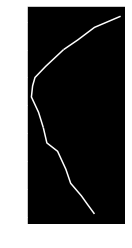

In [68]:
%matplotlib inline
line.plot()

In [15]:
counties = pandas.read_csv('../data/hurr_database/US_counties_COVID19_health_weather_data.csv')

In [16]:
counties = counties[["county", "state", 'lat', "lon"]]

In [18]:
atl_counties = counties[counties.state.isin(atl_states)]

In [23]:
hurr_KATE = location[location["ID"] == 'AL122015']

In [27]:
lats = list(atl_counties["lat"])

In [28]:
longs = list(atl_counties["lon"])

In [53]:
for index, row in atl_counties.head().iterrows():
    print(row[2])

42.33390356774295
42.33390356774295
42.33390356774295
42.33390356774295
42.33390356774295


In [54]:
count = 0
for index, row in atl_counties.iterrows():
    dist = compute_distances_from_county(hurr_KATE, row[2], row[3])
    atl_counties.at[index, "distance_from_hurr"] = dist

In [74]:
for i in range(0, len(atl_counties)):
    if min(atl_counties["distance_from_hurr"].iloc[0]) < 300:
        

[2239.139533123134,
 2176.6768614807174,
 2119.307522538076,
 2056.375987962085,
 1973.5949137578898,
 1832.2421775248774,
 1659.7255482500243,
 1478.742360440598,
 1264.958926503544,
 1026.9560093537903,
 848.2721865890406,
 1003.9587595580089,
 1215.0762651252467,
 1406.9207773268852,
 1613.975483658165,
 1712.829891762399,
 1742.5512814621002,
 1807.202422103487,
 1962.2267126904433,
 2137.054517366599]